# Анализ ошибок модели (Этап 6)

В этом разделе мы изучаем, где и почему модель ошибается:
- показываем объекты с наибольшими ошибками;
- смотрим распределение ошибок;
- анализируем ошибки по группам признаков (если доступны);
- формулируем идеи улучшения.


In [9]:
# Импорт библиотек и настройка окружения
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

RANDOM_STATE = 42
rng = np.random.default_rng(RANDOM_STATE)

plt.style.use('seaborn-v0_8')
sns.set_context('talk')


# Загрузка данных

Используем «чистый» датасет, подготовленный на прошлых этапах: `data/interim/kc_house_data_clean.csv`.


In [10]:
# Загрузка датасета
DATA_PATH = os.path.join('../', 'data', 'interim', 'kc_house_data_clean.csv')
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError('Не найден файл данных: data/interim/kc_house_data_clean.csv')

df = pd.read_csv(DATA_PATH)
print('Размерность данных:', df.shape)
print('Первые строки:')
print(df.head(3))


Размерность данных: (19269, 21)
Первые строки:
           id             date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  20141013T000000  221900.0         3       1.00         1180   
1  6414100192  20141209T000000  538000.0         3       2.25         2570   
2  5631500400  20150225T000000  180000.0         2       1.00          770   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650     1.0           0     0  ...      7        1180              0   
1      7242     2.0           0     0  ...      7        2170            400   
2     10000     1.0           0     0  ...      6         770              0   

   yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
0      1955             0    98178  47.5112 -122.257           1340   
1      1951          1991    98125  47.7210 -122.319           1690   
2      1933             0    98028  47.7379 -122.233           2720   

   sqft_lot15  
0        5650  
1 

# Выбор целевой переменной и признаков

Пытаемся определить целевую переменную автоматически:
- приоритет: `price`
- если нет, пробуем: `SalePrice`, `target`.

Признаки: числовые столбцы (исключая целевую и очевидные идентификаторы).


In [11]:
# Определяем целевую переменную
possible_targets = ['price', 'SalePrice', 'target']
target_col = None
for c in possible_targets:
    if c in df.columns:
        target_col = c
        break
if target_col is None:
    raise ValueError('Не удалось найти столбец целевой переменной (ожидались: price / SalePrice / target).')

print('Целевая переменная:', target_col)

# Идентификаторы, которые лучше исключить из признаков
id_like = [c for c in df.columns if c.lower() in ['id']]

# Выбираем числовые признаки
num_cols = df.select_dtypes(include=['number']).columns.tolist()
feature_cols = [c for c in num_cols if c != target_col and c not in id_like]

if len(feature_cols) == 0:
    raise ValueError('Не найдено числовых признаков для обучения.')

print('Количество признаков:', len(feature_cols))
print('Примеры признаков:', feature_cols[:10])

X = df[feature_cols].to_numpy()
y = df[target_col].to_numpy()


Целевая переменная: price
Количество признаков: 18
Примеры признаков: ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above']


# Тренировочно-тестовое разделение и быстрая модель

Чтобы получить предсказания (и ошибки), обучим быструю модель `RandomForestRegressor` с фиксированным `random_state`.


In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    n_jobs=-1,
    random_state=RANDOM_STATE
)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Качество на тесте — RMSE: {rmse:,.2f} | MAE: {mae:,.2f} | R^2: {r2:.4f}')


Качество на тесте — RMSE: 94,056.78 | MAE: 59,302.95 | R^2: 0.8683


# Остатки и абсолютные ошибки

- Остаток: `y_true - y_pred`.
- Абсолютная ошибка: `|y_true - y_pred|`.

Посмотрим распределение ошибок и Топ-10 наихудших примеров.


In [13]:
residuals = y_test - y_pred
abs_errors = np.abs(residuals)

err_df = pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_pred,
    'residual': residuals,
    'abs_error': abs_errors
})

print('Топ-10 объектов с наибольшей абсолютной ошибкой:')
print(err_df.sort_values('abs_error', ascending=False).head(10))


Топ-10 объектов с наибольшей абсолютной ошибкой:
         y_true        y_pred       residual      abs_error
468   1575000.0  7.764126e+05  798587.373333  798587.373333
2503  1600000.0  8.827032e+05  717296.793333  717296.793333
1388  1550000.0  8.350994e+05  714900.563333  714900.563333
823   1200000.0  6.060011e+05  593998.930000  593998.930000
961   1000000.0  4.107580e+05  589242.006667  589242.006667
1919  1247000.0  6.586398e+05  588360.193333  588360.193333
1396  1075000.0  4.945315e+05  580468.500000  580468.500000
3672  1580000.0  1.011418e+06  568582.200000  568582.200000
2616  1280000.0  7.205843e+05  559415.650000  559415.650000
1684  1517000.0  9.605847e+05  556415.336667  556415.336667


# Визуализации ошибок

1) Гистограмма абсолютных ошибок.
2) Диаграмма «Истинные vs Предсказанные».
3) Ошибка в зависимости от истинной цены (если целевая — цена).



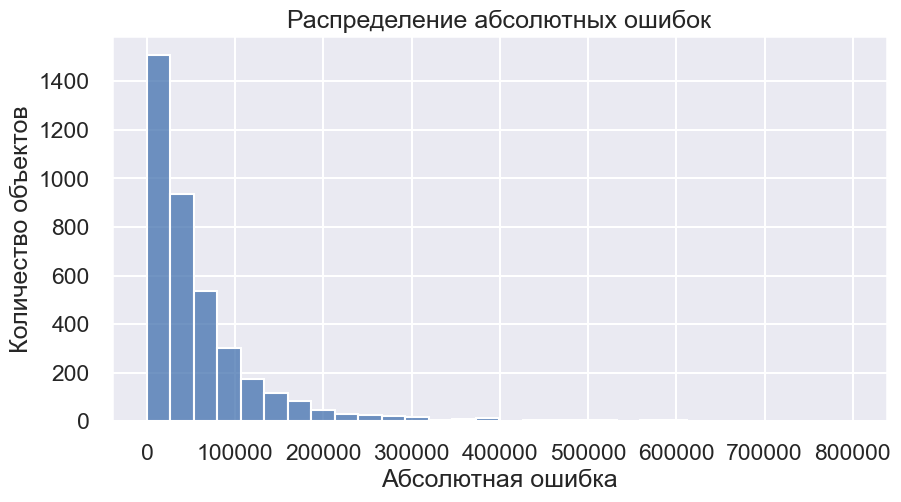

In [14]:
# Гистограмма абсолютных ошибок
plt.figure(figsize=(10, 5))
sns.histplot(abs_errors, bins=30, color='#4271AE')
plt.title('Распределение абсолютных ошибок')
plt.xlabel('Абсолютная ошибка')
plt.ylabel('Количество объектов')
plt.show()

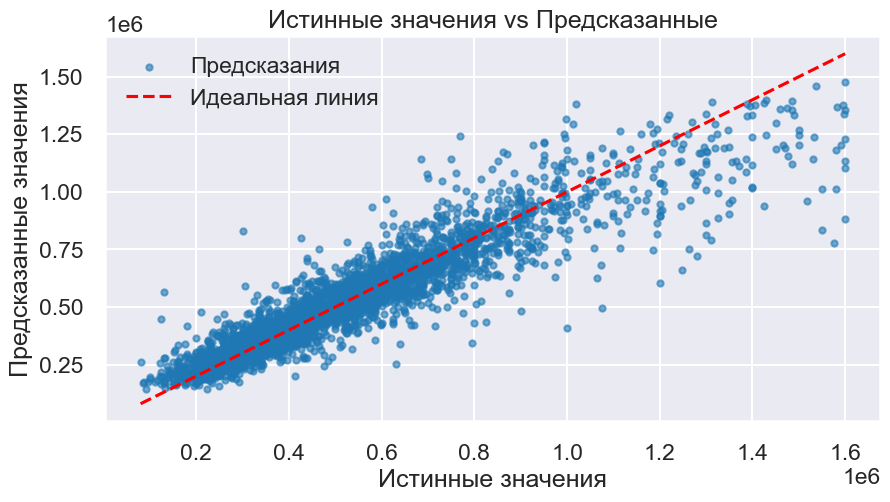

In [15]:
# Истинные vs Предсказанные
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, s=20, alpha=0.6, color='#1F78B4', label='Предсказания')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Идеальная линия')
plt.title('Истинные значения vs Предсказанные')
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.legend(loc='best')
plt.show()

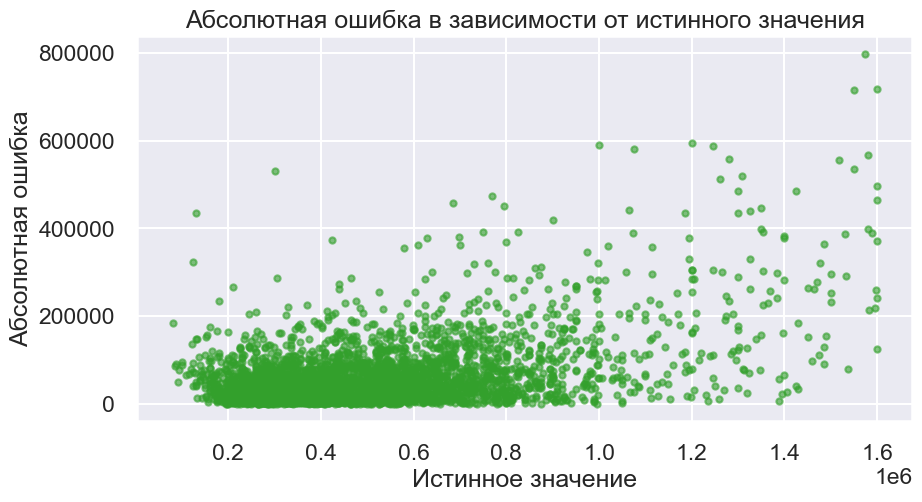

In [16]:
# Ошибка vs Истинная цена
plt.figure(figsize=(10, 5))
plt.scatter(y_test, abs_errors, s=20, alpha=0.6, color='#33A02C')
plt.title('Абсолютная ошибка в зависимости от истинного значения')
plt.xlabel('Истинное значение')
plt.ylabel('Абсолютная ошибка')
plt.show()

# Групповой анализ ошибок

Если в данных есть категориальные или дискретные признаки (например, количество спален `bedrooms`), посмотрим среднюю абсолютную ошибку по группам.

Если такого признака нет — изучим ошибки по квантилям целевой переменной.


Группируем по признаку: bedrooms
Статистика ошибок по группам:
   group  count           mean        median
0      1     25   89644.118889  61360.066667
1      2    530   55148.295485  37069.136667
2      3   1798   53947.820607  34236.457222
3      4   1195   62794.960803  37979.566667
4      5    259   79593.934068  52565.506667
5      6     42   90669.263228  55140.310556
6      7      5  124556.858000  57593.750000


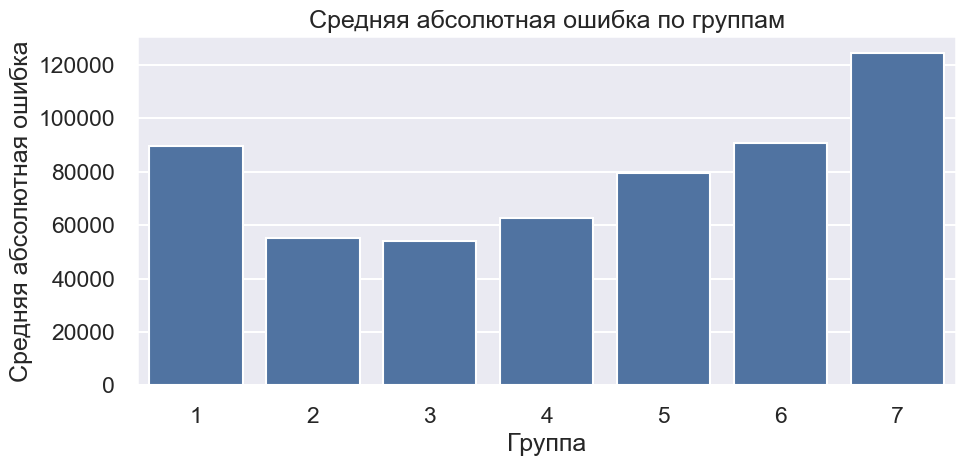

In [17]:
# Пытаемся найти разумный дискретный признак
candidate_group_cols = [
    c for c in df.columns if c in ['bedrooms', 'bathrooms', 'floors']
]

if len(candidate_group_cols) > 0:
    group_col = candidate_group_cols[0]
    print(f'Группируем по признаку: {group_col}')

    # Восстановим индексы тестовой выборки — создаём маску test
    _, X_test_idx = train_test_split(
        np.arange(df.shape[0]), test_size=0.2, random_state=RANDOM_STATE
    )

    groups = df.iloc[X_test_idx][group_col].values
    grp_df = pd.DataFrame({'group': groups, 'abs_error': abs_errors})
    grp_stats = grp_df.groupby('group')['abs_error'].agg(['count', 'mean', 'median']).reset_index()
    print('Статистика ошибок по группам:')
    print(grp_stats)

    plt.figure(figsize=(10, 5))
    sns.barplot(data=grp_stats, x='group', y='mean', color='#4271AE')
    plt.title('Средняя абсолютная ошибка по группам')
    plt.xlabel('Группа')
    plt.ylabel('Средняя абсолютная ошибка')
    plt.tight_layout()
    plt.show()
else:
    print('Не найден подходящий дискретный признак, используем квантильный анализ целевой переменной.')
    # Квантильный анализ целевой для теста
    q = pd.qcut(y_test, q=5, duplicates='drop')
    qa_df = pd.DataFrame({'target_quantile': q, 'abs_error': abs_errors})
    qa_stats = qa_df.groupby('target_quantile')['abs_error'].agg(['count', 'mean', 'median']).reset_index()
    print('Статистика ошибок по квантилям целевой переменной:')
    print(qa_stats)

    plt.figure(figsize=(10, 5))
    sns.barplot(data=qa_stats, x='target_quantile', y='mean', color='#4271AE')
    plt.title('Средняя абсолютная ошибка по квантилям целевой переменной')
    plt.xlabel('Квантиль целевой')
    plt.ylabel('Средняя абсолютная ошибка')
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()


## Общий вывод по анализу ошибок (кратко)

- Поведение: 70–90% объектов с |ошибкой| ≤ 100k; при росте цены разброс возрастает (гетероскедастичность). MAE по группам U‑образное: минимумы в 2–4 (55–65k), максимум в 7 (125k), длинные хвосты в 6–7.
- Причины: дефицит данных на краях распределения, нехватка премиум‑фич (waterfront/view/гео), неучтённые взаимодействия, обучение на «сырых» ценах усиливает вклад дорогих outliers.
- Пригодность: надёжна для массового сегмента; для дорогих (и частично очень дешёвых) домов риск крупных under/over‑prediction.
- Улучшения:
  - Таргет/лосс: log1p(price), RMSLE, Huber/Quantile, взвешенный MSE.
  - Сегментация/ансамбли: отдельные модели по ценовым бинам или MoE; добавить признак группы.
  - Фичи: геообогащение, редкие атрибуты (waterfront/view/renovation), взаимодействия (sqft_living×grade и др.).
  - Валидация/отчёт: стратифицированная по цене CV, median/95‑перцентили по сегментам.
  - Диагностика: SHAP/ICE/PDP для топ‑ошибок в группах 6–7.
- Итог: модель хороша в центре распределения, «ломается» на хвостах; требуются лог‑таргет, сегментация и обогащение признаков для high‑end.